In [ ]:
import zipfile
import os

# Path to the uploaded ZIP file
zip_path = '/content/archive (4) _ 3 categories wala.zip'  # <-- Replace with your actual filename

# Directory to extract to
extract_to = '/content/extracted'
os.makedirs(extract_to, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Extracted to: {extract_to}")


Extracted to: /content/extracted


In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold

In [ ]:
# ===========================
# ⚙️ Setup: Data Directories
# ===========================
dataset_path = "./extracted/dataset"  # Replace if needed
categories = ["with_mask", "without_mask", "incorrect_mask"]
label_map = {cat: idx for idx, cat in enumerate(categories)}

train_images = []
train_labels = []

img_size = (128, 128)

In [ ]:
# ===========================
# 📥 Load and Label Images
# ===========================
for label_name, label_index in label_map.items():
    dir_path = os.path.join(dataset_path, label_name)
    for fname in os.listdir(dir_path):
        if fname.lower().endswith(('.jpg', '.png', '.jpeg')):
            img = Image.open(os.path.join(dir_path, fname)).convert("RGB")
            img = img.resize(img_size)
            img_array = np.array(img)
            if img_array.shape == (128, 128, 3):
                train_images.append(img_array)
                train_labels.append(label_index)

In [ ]:
for label_name in categories:
    print(label_name, len(os.listdir(os.path.join(dataset_path, label_name))))


with_mask 690
without_mask 686
incorrect_mask 703


In [ ]:
# ===========================
# ✅ Convert & One-Hot Encode
# ===========================
train_images = np.array(train_images, dtype='float32') / 255.0
train_labels = to_categorical(np.array(train_labels), num_classes=3)

In [ ]:
# ===========================
# 📊 Split Dataset
# ===========================
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

In [ ]:
# ===========================
# 🔁 Data Augmentation
# ===========================
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)


In [ ]:
# ===========================
# 🧠 Define MobileNetV2 Model
# ===========================
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 32, 32,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 32, 32,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 32, 32,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 32, 32,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 32, 32,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 32, 32,    │     12,288 │ conv2_block2_0_r

 Total params: 7,103,299 (27.10 MB)

 Trainable params: 7,019,651 (26.78 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [ ]:
# ===========================
# 🚀 Train the Model
# ===========================
history = model.fit(
    train_generator,
    epochs=32,
    validation_data=val_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/32
52/52 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.6410 - loss: 0.8284 - val_accuracy: 0.9663 - val_loss: 0.0786
Epoch 2/32
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - accuracy: 0.9791 - loss: 0.0741 - val_accuracy: 0.9904 - val_loss: 0.0248
Epoch 3/32
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 0.9895 - loss: 0.0282 - val_accuracy: 0.9976 - val_loss: 0.0084
Epoch 4/32
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - accuracy: 0.9979 - loss: 0.0150 - val_accuracy: 0.9976 - val_loss: 0.0079
Epoch 5/32
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 181ms/step - accuracy: 0.9952 - loss: 0.0161 - val_accuracy: 0.9976 - val_loss: 0.0052
Epoch 6/32
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - accuracy: 0.9965 - loss: 0.0132 - val_accuracy: 0.9976 - val_loss: 0.0038
Epoch 7/32
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - accuracy: 0.9981 - loss: 0.0074 - val_accuracy: 0.9928 - val_loss: 0.0104
Epoch 8/32
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - accuracy: 0.9988 - loss: 0.0045 - val_accuracy: 0.

🟢 Final Training Accuracy: 1.0000
🔵 Final Validation Accuracy: 1.0000
🟢 Final Training Loss: 0.0007
🔵 Final Validation Loss: 0.0004


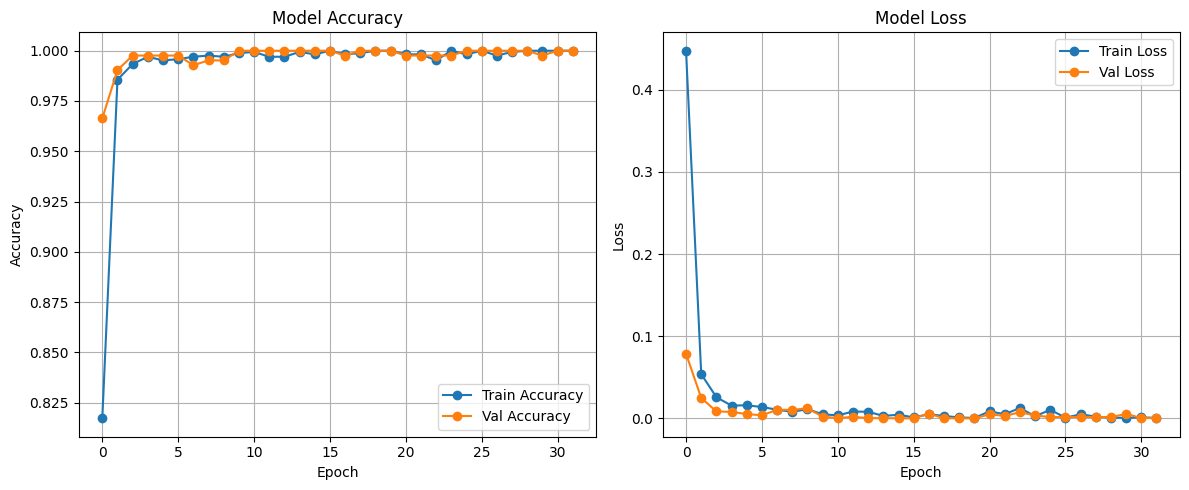

In [ ]:
# ===========================
# 📈 Plot Accuracy & Loss
# ===========================
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

print(f"🟢 Final Training Accuracy: {train_acc:.4f}")
print(f"🔵 Final Validation Accuracy: {val_acc:.4f}")
print(f"🟢 Final Training Loss: {train_loss:.4f}")
print(f"🔵 Final Validation Loss: {val_loss:.4f}")

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



📂 Fold 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.6618 - loss: 0.8276 - val_accuracy: 0.9038 - val_loss: 0.2376
Epoch 2/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 288ms/step - accuracy: 0.9689 - loss: 0.1155 - val_accuracy: 0.9688 - val_loss: 0.1042
Epoch 3/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 252ms/step - accuracy: 0.9942 - loss: 0.0334 - val_accuracy: 0.9808 - val_loss: 0.0822
Epoch 4/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 293ms/step - accuracy: 0.9919 - loss: 0.0296 - val_accuracy: 0.9832 - val_loss: 0.0746
Epoch 5/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - accuracy: 0.9954 - loss: 0.0136 - val_accuracy: 0.9856 - val_loss: 0.0591
Epoch 6/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 251ms/step - accuracy: 0.9974 - loss: 0.0104 - val_accuracy: 0.9832 - val_loss: 0.0563
Epoch 7/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 285ms/step - accuracy: 0.9959 - loss: 0.0134 - val_accuracy: 0.9856 - val_loss: 0.0548
Epoch 8/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 273ms/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 0.9

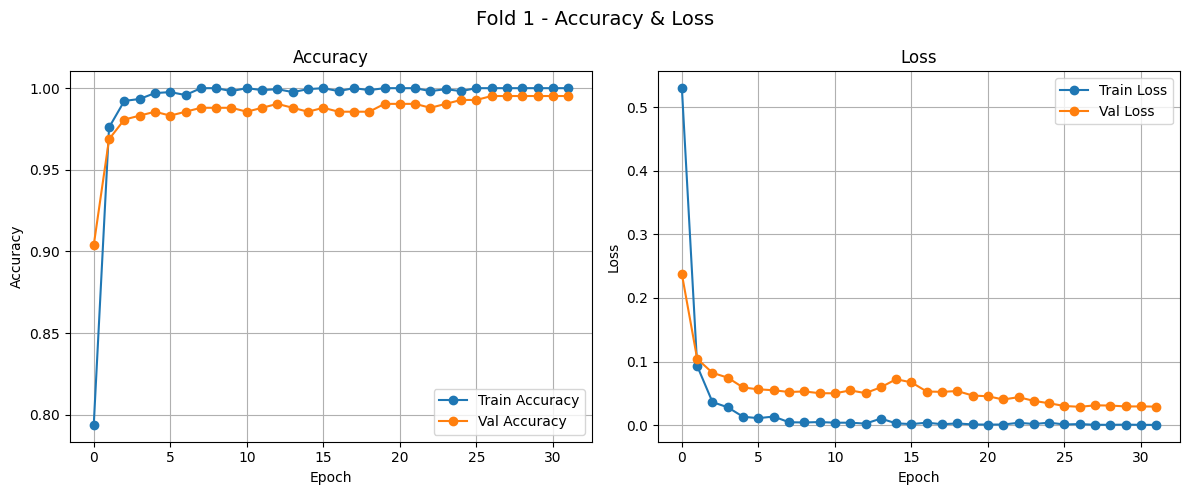


📂 Fold 2/5
Epoch 1/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.6305 - loss: 0.8235 - val_accuracy: 0.9231 - val_loss: 0.2062
Epoch 2/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 302ms/step - accuracy: 0.9687 - loss: 0.1092 - val_accuracy: 0.9663 - val_loss: 0.1016
Epoch 3/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 301ms/step - accuracy: 0.9910 - loss: 0.0359 - val_accuracy: 0.9784 - val_loss: 0.0575
Epoch 4/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 257ms/step - accuracy: 0.9981 - loss: 0.0200 - val_accuracy: 0.9832 - val_loss: 0.0444
Epoch 5/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 297ms/step - accuracy: 0.9969 - loss: 0.0138 - val_accuracy: 0.9808 - val_loss: 0.0516
Epoch 6/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 256ms/step - accuracy: 0.9955 - loss: 0.0133 - val_accuracy: 0.9832 - val_loss: 0.0287
Epoch 7/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 296ms/step - accuracy: 0.9992 - loss: 0.0073 - val_accuracy: 0.9856 - val_loss: 0.0372
Epoch 8/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 296ms/step - accuracy: 1.0000 - loss: 0.0067 - val_a

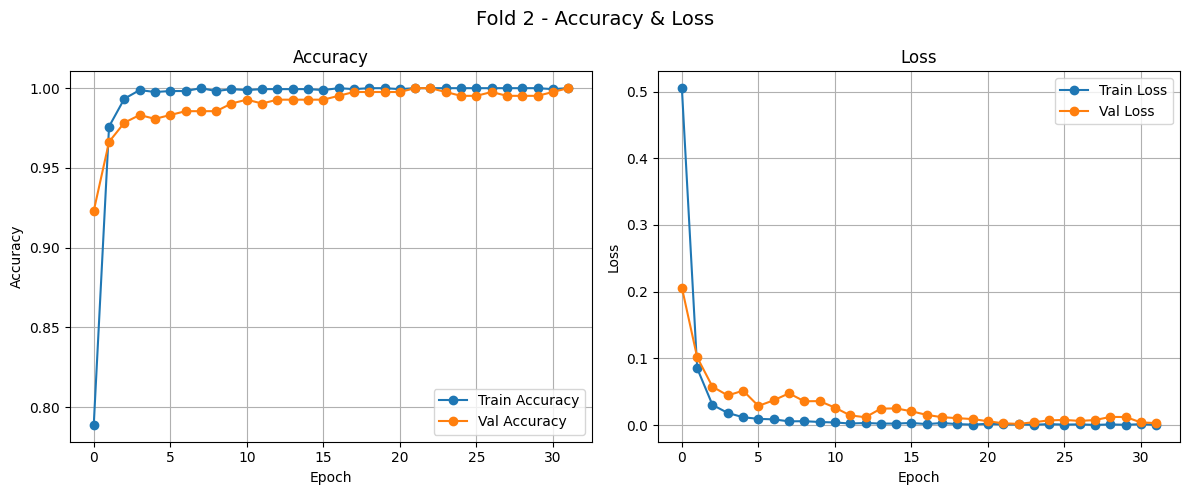


📂 Fold 3/5
Epoch 1/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.5895 - loss: 1.0432 - val_accuracy: 0.8606 - val_loss: 0.3998
Epoch 2/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 261ms/step - accuracy: 0.9607 - loss: 0.1477 - val_accuracy: 0.9303 - val_loss: 0.2089
Epoch 3/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 290ms/step - accuracy: 0.9931 - loss: 0.0490 - val_accuracy: 0.9279 - val_loss: 0.1880
Epoch 4/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 258ms/step - accuracy: 0.9912 - loss: 0.0361 - val_accuracy: 0.9231 - val_loss: 0.2139
Epoch 5/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 294ms/step - accuracy: 0.9926 - loss: 0.0269 - val_accuracy: 0.9255 - val_loss: 0.2441
Epoch 6/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 292ms/step - accuracy: 0.9950 - loss: 0.0157 - val_accuracy: 0.9471 - val_loss: 0.1668
Epoch 7/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 257ms/step - accuracy: 0.9995 - loss: 0.0067 - val_accuracy: 0.9567 - val_loss: 0.1127
Epoch 8/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 292ms/step - accuracy: 0.9979 - loss: 0.0074 - val_a

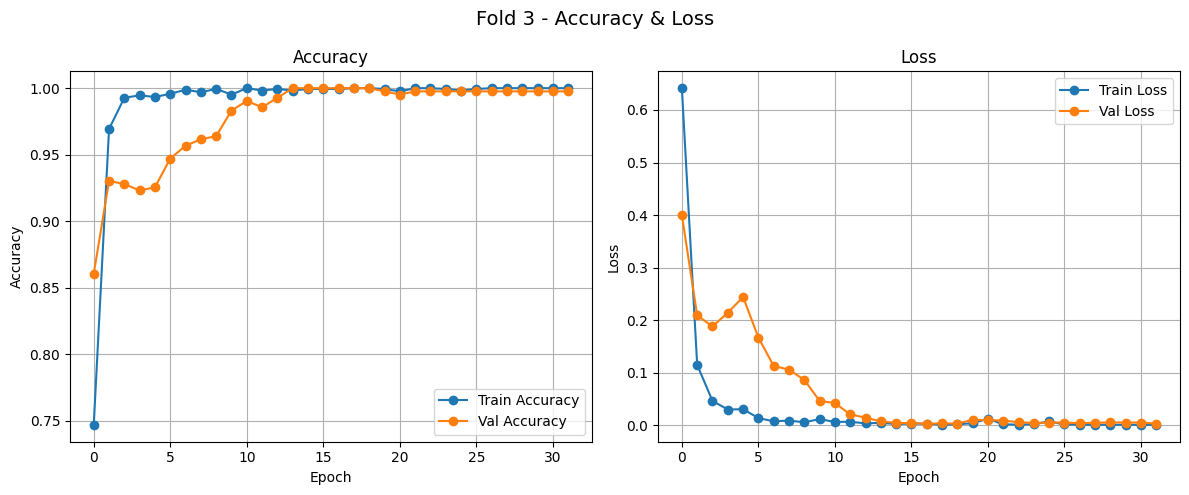


📂 Fold 4/5
Epoch 1/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 407s 1s/step - accuracy: 0.5998 - loss: 0.8608 - val_accuracy: 0.8726 - val_loss: 0.3051
Epoch 2/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 291ms/step - accuracy: 0.9601 - loss: 0.1198 - val_accuracy: 0.9087 - val_loss: 0.2069
Epoch 3/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 293ms/step - accuracy: 0.9930 - loss: 0.0404 - val_accuracy: 0.9471 - val_loss: 0.1565
Epoch 4/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 259ms/step - accuracy: 0.9902 - loss: 0.0270 - val_accuracy: 0.9688 - val_loss: 0.1093
Epoch 5/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 281ms/step - accuracy: 0.9952 - loss: 0.0236 - val_accuracy: 0.9808 - val_loss: 0.0763
Epoch 6/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 288ms/step - accuracy: 0.9996 - loss: 0.0096 - val_accuracy: 0.9856 - val_loss: 0.0615
Epoch 7/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 260ms/step - accuracy: 0.9979 - loss: 0.0090 - val_accuracy: 0.9928 - val_loss: 0.0470
Epoch 8/32
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 292ms/step - accuracy: 0.9985 - loss: 0.0090 - val_

In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# ===========================
# ⚙️ Load and Preprocess Data
# ===========================
dataset_path = "./extracted/dataset"
categories = ["with_mask", "without_mask", "incorrect_mask"]
label_map = {cat: idx for idx, cat in enumerate(categories)}

img_size = (128, 128)
images = []
labels = []

for label_name, label_index in label_map.items():
    dir_path = os.path.join(dataset_path, label_name)
    for fname in os.listdir(dir_path):
        if fname.lower().endswith(('.jpg', '.png', '.jpeg')):
            img = Image.open(os.path.join(dir_path, fname)).convert("RGB")
            img = img.resize(img_size)
            img_array = np.array(img)
            if img_array.shape == (128, 128, 3):
                images.append(img_array)
                labels.append(label_index)

X = np.array(images, dtype='float32') / 255.0
y = np.array(labels)
y_cat = to_categorical(y, num_classes=3)

# ===========================
# 🔁 K-Fold Cross Validation
# ===========================
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

fold = 1
acc_per_fold = []
loss_per_fold = []

for train_index, val_index in skf.split(X, y):
    print(f"\n📂 Fold {fold}/{k}")

    # Split data
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y_cat[train_index], y_cat[val_index]

    # Data augmentation
    train_datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    val_datagen = ImageDataGenerator()

    train_generator = train_datagen.flow(X_train, y_train, batch_size=64)
    val_generator = val_datagen.flow(X_val, y_val, batch_size=64)

    # Create new model
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(128, 128, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(3, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Train
    history = model.fit(
        train_generator,
        epochs=32,
        validation_data=val_generator,
        verbose=1
    )

    # Evaluate
    scores = model.evaluate(val_generator, verbose=0)
    acc_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    print(f"✅ Fold {fold} - Loss: {scores[0]:.4f} - Accuracy: {scores[1]:.4f}")

    # ===========================
    # 📊 Plot for this fold
    # ===========================
    plt.figure(figsize=(12, 5))
    plt.suptitle(f'Fold {fold} - Accuracy & Loss', fontsize=14)

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    fold += 1

# ===========================
# 🧮 Final Summary
# ===========================
print("\n🔚 K-Fold Cross Validation Results:")
for i in range(k):
    print(f"Fold {i+1} — Accuracy: {acc_per_fold[i]:.4f}, Loss: {loss_per_fold[i]:.4f}")

print(f"\n📈 Average Accuracy: {np.mean(acc_per_fold):.4f}")
print(f"📉 Average Loss: {np.mean(loss_per_fold):.4f}")


In [ ]:
# ===========================
# 💾 Save the Model
# ===========================
model.save("DenseNet_mask_multiclass.h5")
print("✅ Model saved as mobilenet_mask_multiclass.h5")


In [ ]:
import tensorflow as tf

# Load your trained Keras model
model = tf.keras.models.load_model("/content/mobilenet_mask_multiclass.h5")

# Create converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# OPTIONAL: Enable optimization for size and speed
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# OPTIONAL: If you want INT8 quantization (smallest & fastest), you also need to set a representative dataset.
# For simplicity, here we keep FP16/FP32. Let me know if you want full INT8 code.

# Convert model
tflite_model = converter.convert()

# Save to file
with open("mobilenet_mask_detector.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ TFLite model saved as mobilenet_mask_detector.tflite")


In [ ]:
import tensorflow as tf
import numpy as np

# ===========================
# 📦 Load Trained Keras Model
# ===========================
model = tf.keras.models.load_model("mobilenet_mask_multiclass.h5")
print("✅ Loaded Keras model.")

# ===========================
# 🧪 Define Representative Dataset
# ===========================
# Make sure X_train is available and normalized (0-1)
# Pick 100 samples to simulate inference during conversion
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(X_train).batch(1).take(100):
        yield [tf.cast(input_value, tf.float32)]

# ===========================
# 🔁 Convert to Quantized TFLite
# ===========================
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Enable optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Provide representative dataset for INT8
converter.representative_dataset = representative_data_gen

# Set inference types
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

# 🔄 Convert the model
quant_model = converter.convert()

# ===========================
# 💾 Save TFLite Quantized Model
# ===========================
with open("mobilenet_mask_multiclass_int8.tflite", "wb") as f:
    f.write(quant_model)

print("✅ INT8 quantized TFLite model saved as mobilenet_mask_multiclass_int8.tflite")


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import time
from PIL import Image

# === Load Haar Cascade for Face Detection ===
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# === Load the quantized TFLite model ===
interpreter = tf.lite.Interpreter(model_path="mobilenet_mask_multiclass_int8.tflite")
interpreter.allocate_tensors()
print("✅ INT8 TFLite model loaded.")

# === Get input/output details ===
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_index = input_details[0]['index']
output_index = output_details[0]['index']
input_scale, input_zero_point = input_details[0]['quantization']
output_scale, output_zero_point = output_details[0]['quantization']

# === Label Mapping ===
class_names = ["With Mask", "Without Mask", "Improper Mask"]

def preprocess_face(face_img):
    """Preprocess cropped face image for TFLite model."""
    face_resized = cv2.resize(face_img, (128, 128))
    face_normalized = face_resized.astype(np.float32) / 255.0
    face_quantized = face_normalized / input_scale + input_zero_point
    face_quantized = face_quantized.astype(np.uint8)
    return np.expand_dims(face_quantized, axis=0)

def predict_face(face_img):
    input_tensor = preprocess_face(face_img)
    interpreter.set_tensor(input_index, input_tensor)
    interpreter.invoke()
    output = interpreter.get_tensor(output_index)[0]
    probabilities = (output.astype(np.float32) - output_zero_point) * output_scale
    predicted_index = np.argmax(probabilities)
    return class_names[predicted_index], np.max(probabilities)

def detect_and_predict(image_path):
    """Detects faces and predicts mask status for each."""
    # Load image
    image = cv2.imread(image_path)
    orig = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    for (x, y, w, h) in faces:
        face = image[y:y+h, x:x+w]
        if face.size == 0:
            continue
        label, confidence = predict_face(face)

        # Draw bounding box and label
        color = (0, 255, 0) if label == "With Mask" else ((0, 255, 255) if label == "Improper Mask" else (0, 0, 255))
        cv2.rectangle(orig, (x, y), (x+w, y+h), color, 2)
        cv2.putText(orig, f"{label} ({confidence*100:.1f}%)", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # Show the result
    cv2.imshow("Mask Detection", orig)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# ====== USAGE ======
image_path = "/content/download.jpg"  # Change this path to your image
detect_and_predict(image_path)
